<a href="https://colab.research.google.com/github/ThuTang/Quora-Insincere-Questions-Classification/blob/master/THH_HN_ML101_Quora_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, SimpleRNN
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!pip install -q kaggle

In [5]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Jul  7 01:32 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c quora-insincere-questions-classification

 61% 33.0M/54.4M [00:00<00:00, 50.1MB/s]
100% 54.4M/54.4M [00:00<00:00, 85.6MB/s]
100% 5.94G/5.96G [00:54<00:00, 124MB/s]
100% 5.96G/5.96G [00:54<00:00, 118MB/s]
  0% 0.00/4.08M [00:00<?, ?B/s]
100% 4.08M/4.08M [00:00<00:00, 67.2MB/s]
 51% 8.00M/15.7M [00:00<00:00, 82.3MB/s]
100% 15.7M/15.7M [00:00<00:00, 76.4MB/s]


In [8]:
!unzip \*.zip

Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

4 archives were successfully processed.


In [9]:
## first look at our data:
quora = pd.read_csv('train.csv')
quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [10]:
quora_test = pd.read_csv('test.csv')
quora_test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [11]:
print(quora.shape)
print(quora_test.shape)

quora.isnull().sum()

(1306122, 3)
(375806, 2)


qid              0
question_text    0
target           0
dtype: int64

EDA part

In [12]:
quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [13]:
X = quora.drop(['qid', 'target'], axis=1)
y = quora['target']
X.shape, y.shape

((1306122, 1), (1306122,))

In [45]:
n_0 = y.value_counts()[0]
n_1 = y.value_counts()[1]
print('{} questions are tagged as sincere.'.format(n_0))
print('{} questions are tagged as insincere.'.format(n_1))
print('{}% of the questions in the train set are tagged as insincere.'.format((n_1*100/(n_1 + n_0)).round(2)))


np.array(X[y==1])[np.random.choice(len(np.array(X[y==1])), size=15, replace=False)]


1225312 questions are tagged as sincere.
80810 questions are tagged as insincere.
6.19% of the questions in the train set are tagged as insincere.


array([['Do the Indian Muslims think themselves to be secular?'],
       ['Why do teenagers talk acoustically ununderstandable garbage?'],
       ["Is Trump keeping the Muller investigation front and center to eventually force Muller to investigate Clinton's collusion with Russian interest to rig an election with the fake dossier?"],
       ['If you are a professor of international law, do you think Trump can be prosecuted for crimes against humanity by splitting up thousands of immigrant families and holding babies and toddlers in detention centers?'],
       ["Is it true that white woman shouldn't get buttock augmentation surgery?"],
       ['Is it ok for a 12 year old boy to have sex with a 10 year old girl?'],
       ["Why are Christian's so excited about Trump being president? I see nothing moral or wholesome about this creature."],
       ['How many times in Tennessee can you marry different people I have always been told six times?'],
       ['Would you suck a gorillas nuts for 

In [46]:
np.array(X[y==0])[np.random.choice(len(np.array(X[y==0])), size=15, replace=False)]

array([['Does free will necessitate a soul in this seemingly deterministic universe?'],
       ['How has The Walt Disney company influenced modern consumerism around the world?'],
       ['What are examples of cultural relativism?'],
       ['How do I learn German without like forgetting it?'],
       ['How do I figure out the value of a business for sale or price I should pay?'],
       ['Do the different taste of water?'],
       ['Why was the Industrial Revolution an extraordinary jump forward in history?'],
       ['Why do my 17-year-old twin sisters hold hands in public and hug each other all the time?'],
       ['How do some companies achieve global commodity trades?'],
       ['What happens if you shoot at a Jedi with a minigun?'],
       ['Have you ever heard about 3rd eye meditation. Is it really open. Can we see anybody at anytime by opening 3rd eye?'],
       ['How do I get a good book on Sanskrit with English as a medium?'],
       ['Are you Quora famous?'],
       ['What p

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(stop_words='english')
svd = TruncatedSVD(n_components=1, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer', vectorizer), ('svd', svd)])

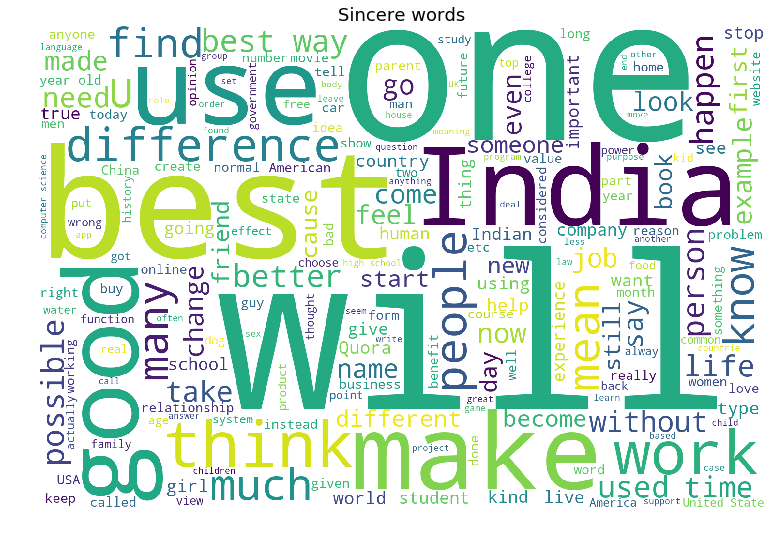

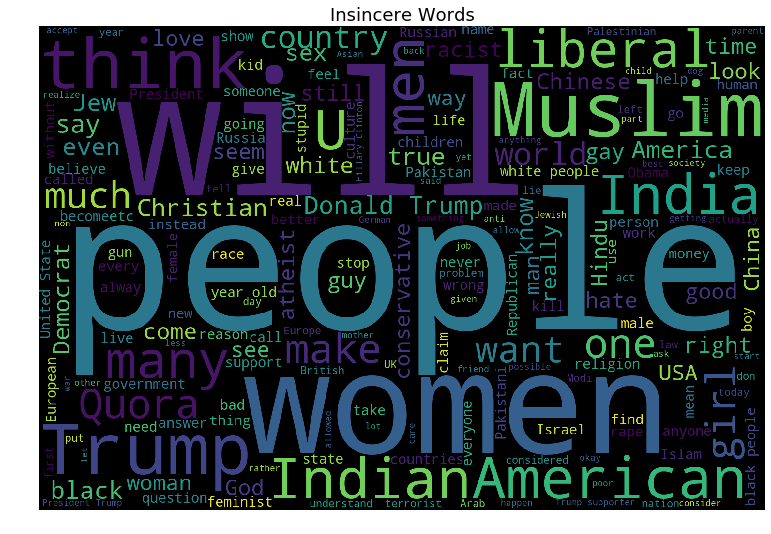

In [17]:
## word cloud:

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

def wordcloud_draw(data, title, color='black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=1500,
                      height=1000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'fontsize':18})
    plt.axis('off')
    plt.show()

title = "Sincere words"
wordcloud_draw(quora[quora['target']==0]['question_text'], title, 'white')
title = "Insincere Words"
wordcloud_draw(quora[quora['target']==1]['question_text'], title, 'black')

In [18]:
# Building the latent semantic analysis dataframe for sincere and insincere questions

lsa_insincere = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere = pd.DataFrame(svd.components_)
topics_insincere.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()

lsa_sincere = preprocessing_pipe.fit_transform(X[y==0]['question_text'])
topics_sincere = pd.DataFrame(svd.components_)
topics_sincere.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()

topics_insincere.shape, topics_sincere.shape

((1, 37479), (1, 188697))

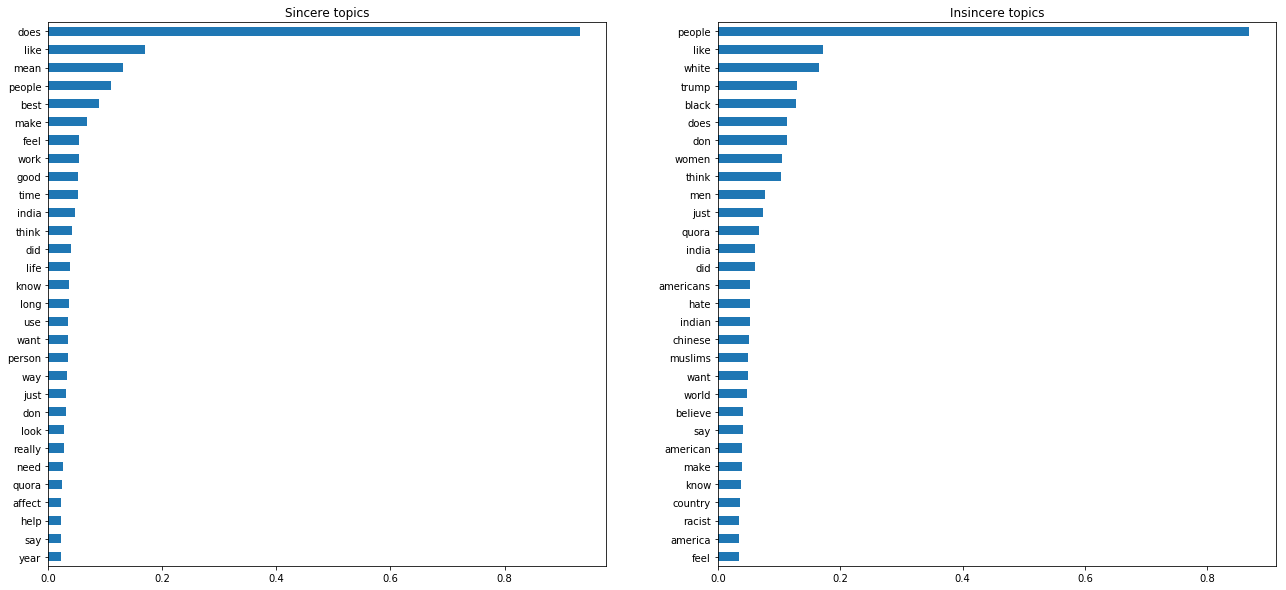

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(22,10));

topics_sincere.iloc[0].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=axes[0], title = 'Sincere topics');
topics_insincere.iloc[0].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=axes[1],title = 'Insincere topics');

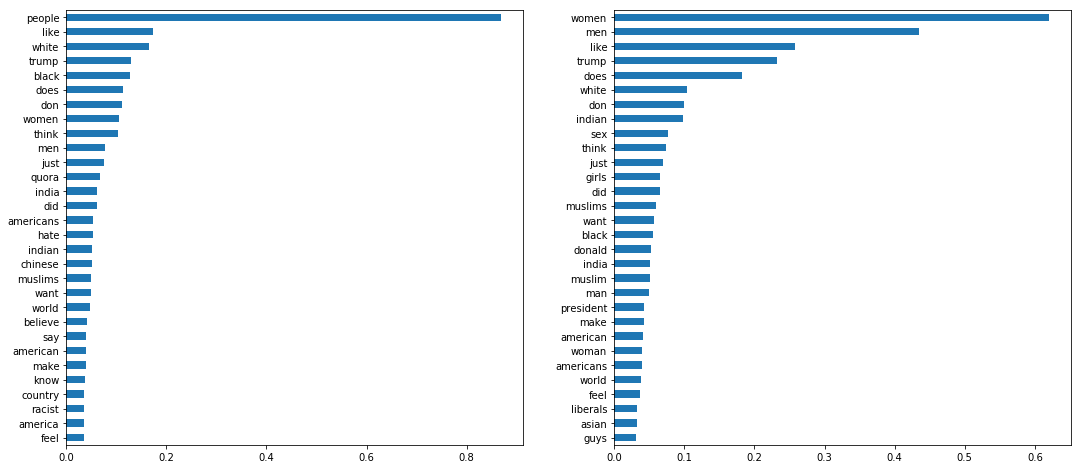

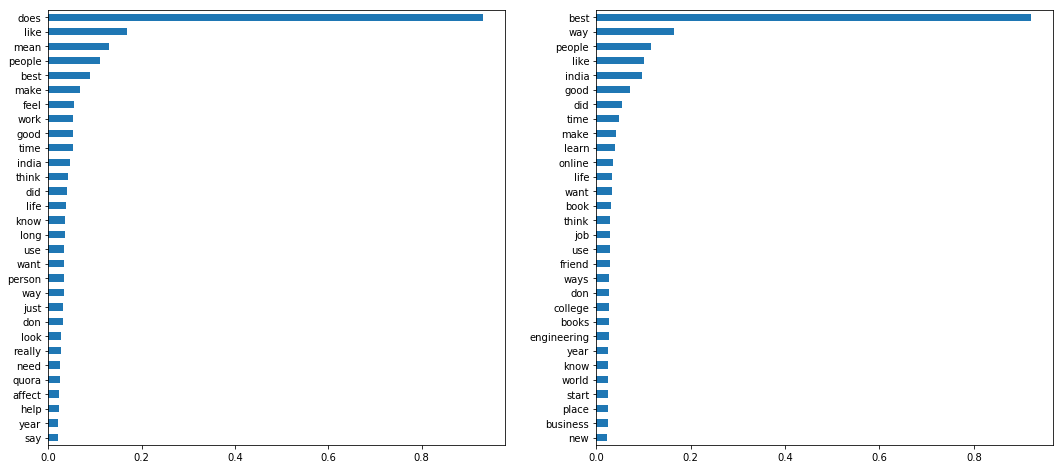

In [21]:
vectorizer = CountVectorizer(stop_words='english')
svd = TruncatedSVD(n_components=2, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer', vectorizer), ('svd', svd)])

# Building the latent semantic analysis dataframe for sincere and insincere questions

lsa_insincere_2 = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere_2 = pd.DataFrame(svd.components_)
topics_insincere_2.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()

lsa_sincere_2 = preprocessing_pipe.fit_transform(X[y==0]['question_text'])
topics_sincere_2 = pd.DataFrame(svd.components_)
topics_sincere_2.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()


fig_1, axes_1 = plt.subplots(1, 2, figsize=(18, 8))
for i, ax in enumerate(axes_1.flat) :
    topics_insincere_2.iloc[i].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=ax)
    
fig_2, axes_2 = plt.subplots(1, 2, figsize=(18, 8))
for i, ax in enumerate(axes_2.flat):
    topics_sincere_2.iloc[i].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=ax)

In [0]:
vectorizer_22 = CountVectorizer(stop_words='english', ngram_range=(2, 2))
svd_10c = TruncatedSVD(n_components=9, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer_22', vectorizer_22), ('svd_10c', svd_10c)])

# Building the latent semantic analysis dataframe for insincere questions

lsa_insincere_10c = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere_10c = pd.DataFrame(svd_10c.components_)
topics_insincere_10c.columns = preprocessing_pipe.named_steps['vectorizer_22'].get_feature_names()

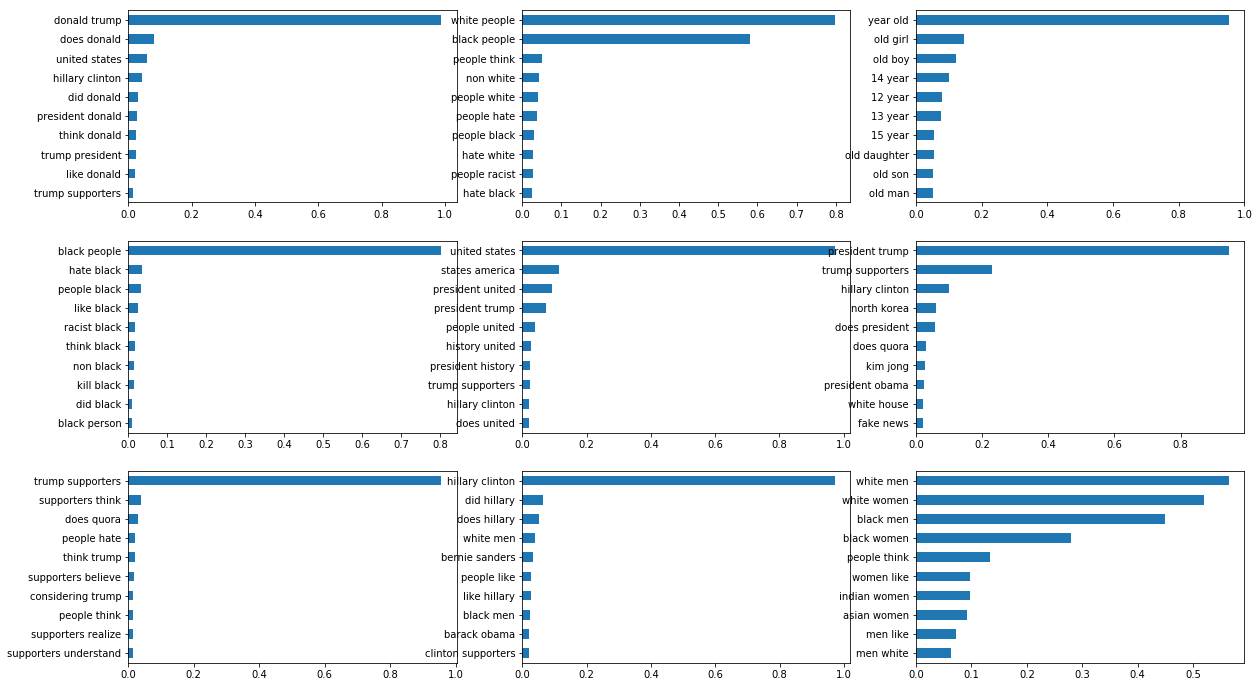

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    topics_insincere_10c.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)

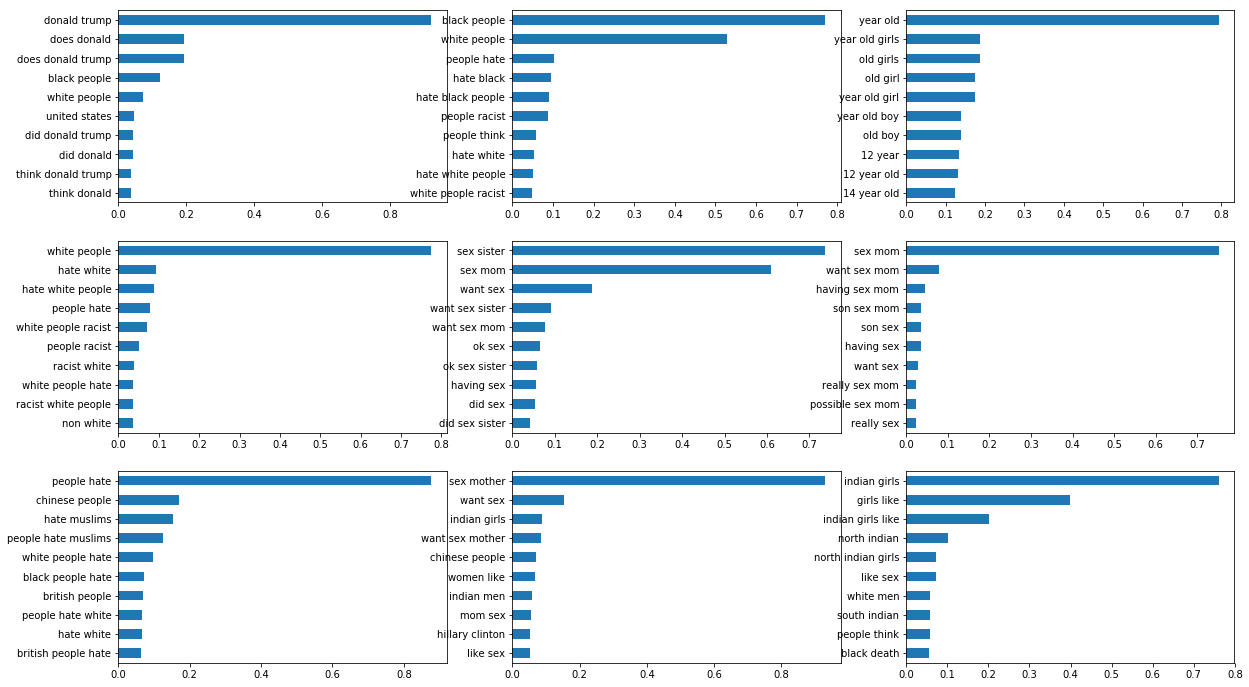

In [47]:
vectorizer_23 = TfidfVectorizer(stop_words='english', ngram_range=(2, 3))
svd_9c = TruncatedSVD(n_components=9, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer_23', vectorizer_23), ('svd_9c', svd_9c)])

# Building the latent semantic analysis dataframe for insincere questions

lsa_insincere_9c = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere_9c = pd.DataFrame(svd_9c.components_)
topics_insincere_9c.columns = preprocessing_pipe.named_steps['vectorizer_23'].get_feature_names()

fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    topics_insincere_9c.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)

Preprocessing part

In [0]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [27]:
from tqdm import tqdm
tqdm.pandas()
## populate the vocabulary and display the first 5 elements and their count
sentences = quora["question_text"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 1306122/1306122 [00:04<00:00, 274654.57it/s]


{'How': 261930, 'did': 33489, 'Quebec': 97, 'nationalists': 91, 'see': 9003}


In [0]:
### start cleanning data, embedding part


### https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings



def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x
  
import re

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x
  
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispell_dict = {'colour':'color',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'social medium',
                'whatsapp': 'social medium',
                'snapchat': 'social medium'

                }
mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [29]:
from tqdm import tqdm
tqdm.pandas()
quora["question_text"] = quora["question_text"].progress_apply(lambda x: clean_text(x))
quora["question_text"] = quora["question_text"].progress_apply(lambda x: clean_numbers(x))
quora["question_text"] = quora["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
sentences = quora["question_text"].apply(lambda x: x.split())

100%|██████████| 1306122/1306122 [00:05<00:00, 222693.85it/s]


Embedding part:

In [0]:
## split into train and valid sample with ratio 70 - 30
df_train, df_valid = train_test_split(quora, test_size=0.3, random_state=2019)


## some config values 
embed_size = 300 # how big is each word vector (in this sample)
max_features = 50000 # how many unique words to use (num rows in embedding vector)
maxlen = 100 # max number of words in a question to use


## fill up the missing values
x_train = df_train["question_text"].fillna("_na_").values
x_valid = df_valid["question_text"].fillna("_na_").values
x_test = quora_test["question_text"].fillna("_na_").values


## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))
train_X = tokenizer.texts_to_sequences(x_train)
val_X = tokenizer.texts_to_sequences(x_valid)
test_X = tokenizer.texts_to_sequences(quora_test)



## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)



## Get the target values
y_train = df_train['target'].values
y_valid = df_valid['target'].values

### https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do


Not using embedding and run RNN (try to compare the differences between simple RNN and LSTM and GRU)

In [35]:
## no embedding and simple RNN
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = SimpleRNN(64, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_simpleRNN = Model(inputs=inp, outputs=x)
model_simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_simpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

In [36]:
## no embedding and CuDNNLSTM
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = CuDNNLSTM(64, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_LSTM = Model(inputs=inp, outputs=x)
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_LSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100, 64)           93696     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total para

In [37]:
## no embedding and CuDNNGRU
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = CuDNNGRU(64, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_GRU = Model(inputs=inp, outputs=x)
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_GRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100, 64)           70272     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total para

In [38]:
## Train simple RNN
model_simpleRNN.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 148s 161us/step - loss: 0.1264 - acc: 0.9527 - val_loss: 0.1109 - val_acc: 0.9556
Epoch 2/4
914285/914285 [==============================] - 147s 161us/step - loss: 0.0979 - acc: 0.9611 - val_loss: 0.1113 - val_acc: 0.9552
Epoch 3/4
914285/914285 [==============================] - 146s 160us/step - loss: 0.0796 - acc: 0.9691 - val_loss: 0.1167 - val_acc: 0.9543
Epoch 4/4
914285/914285 [==============================] - 147s 160us/step - loss: 0.0618 - acc: 0.9764 - val_loss: 0.1348 - val_acc: 0.9528


In [39]:
## Train LSTM
model_LSTM.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 65s 72us/step - loss: 0.1310 - acc: 0.9518 - val_loss: 0.1104 - val_acc: 0.9559
Epoch 2/4
914285/914285 [==============================] - 63s 69us/step - loss: 0.1001 - acc: 0.9601 - val_loss: 0.1092 - val_acc: 0.9569
Epoch 3/4
914285/914285 [==============================] - 63s 69us/step - loss: 0.0863 - acc: 0.9655 - val_loss: 0.1144 - val_acc: 0.9563
Epoch 4/4
914285/914285 [==============================] - 64s 70us/step - loss: 0.0722 - acc: 0.9714 - val_loss: 0.1254 - val_acc: 0.9537


In [40]:
## Train GRU
model_GRU.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 58s 63us/step - loss: 0.1294 - acc: 0.9521 - val_loss: 0.1106 - val_acc: 0.9560
Epoch 2/4
914285/914285 [==============================] - 57s 63us/step - loss: 0.1001 - acc: 0.9600 - val_loss: 0.1089 - val_acc: 0.9569
Epoch 3/4
914285/914285 [==============================] - 58s 63us/step - loss: 0.0858 - acc: 0.9660 - val_loss: 0.1150 - val_acc: 0.9551
Epoch 4/4
914285/914285 [==============================] - 58s 63us/step - loss: 0.0708 - acc: 0.9720 - val_loss: 0.1303 - val_acc: 0.9537


In [79]:
## Fit valid simple RNN

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns


pred_simpleRNN_val_y = model_simpleRNN.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_simpleRNN_val_y>thresh).astype(int))))

391837/391837 [==============================] - 32s 82us/step
F1 score at threshold 0.25 is 0.6105902745419641
F1 score at threshold 0.26 is 0.6108637243297071
F1 score at threshold 0.27 is 0.611471963944174
F1 score at threshold 0.28 is 0.6115024146290251
F1 score at threshold 0.29 is 0.6114041504639433
F1 score at threshold 0.3 is 0.6105320367243153
F1 score at threshold 0.31 is 0.6101522445305466
F1 score at threshold 0.32 is 0.6100779015876145
F1 score at threshold 0.33 is 0.6099964241725933
F1 score at threshold 0.34 is 0.6103750550374255
F1 score at threshold 0.35 is 0.609412476065706
F1 score at threshold 0.36 is 0.6082754700125879
F1 score at threshold 0.37 is 0.6070705624961662
F1 score at threshold 0.38 is 0.6055801503140121
F1 score at threshold 0.39 is 0.603858120721842
F1 score at threshold 0.4 is 0.603014236212583
F1 score at threshold 0.41 is 0.6016806722689075
F1 score at threshold 0.42 is 0.6002285133934239
F1 score at threshold 0.43 is 0.5988758303525804
F1 score at 

In [80]:
length_val_X = 391837
y_pred_simpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_simpleRNN_val_y[i,0]> 0.38:
    y_pred_simpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_simpleRNN)))
 

[[357977   9468]
 [  9687  14705]]


In [81]:
cr = classification_report(y_valid, y_pred_simpleRNN)
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    367445
           1       0.61      0.60      0.61     24392

    accuracy                           0.95    391837
   macro avg       0.79      0.79      0.79    391837
weighted avg       0.95      0.95      0.95    391837



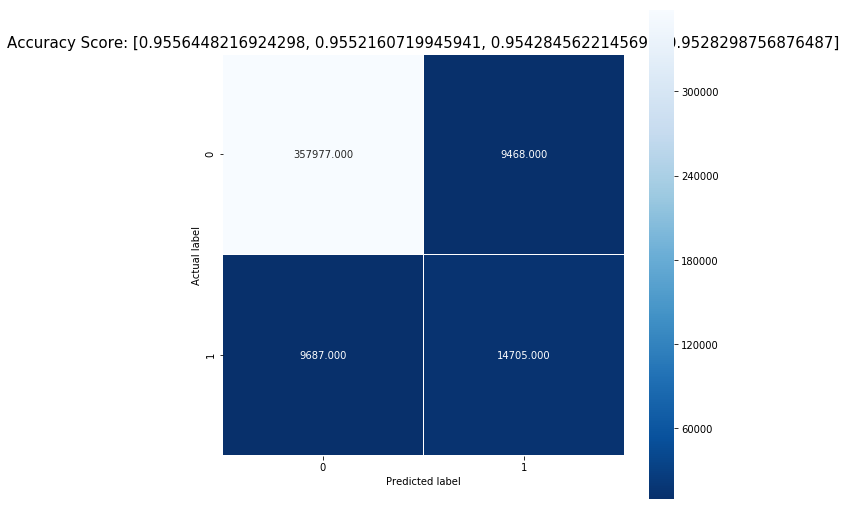

In [82]:
def draw_confusion_matrix_with_seaborn(test_label, predictions, score):
    cm = metrics.confusion_matrix(test_label, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    #plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
    plt.show()
    
    
draw_confusion_matrix_with_seaborn(y_valid, y_pred_simpleRNN, model_simpleRNN.history.history['val_acc'])  

In [83]:
## Fit valid LSTM

pred_LSTM_val_y = model_LSTM.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_LSTM_val_y>thresh).astype(int))))

391837/391837 [==============================] - 6s 16us/step
F1 score at threshold 0.25 is 0.6199549415812361
F1 score at threshold 0.26 is 0.6213523759146611
F1 score at threshold 0.27 is 0.6223787417960621
F1 score at threshold 0.28 is 0.6230878212370653
F1 score at threshold 0.29 is 0.6235415423020566
F1 score at threshold 0.3 is 0.6240163590221103
F1 score at threshold 0.31 is 0.6245652773944245
F1 score at threshold 0.32 is 0.6245844708154585
F1 score at threshold 0.33 is 0.6242298256456354
F1 score at threshold 0.34 is 0.624280293734544
F1 score at threshold 0.35 is 0.6245742231356206
F1 score at threshold 0.36 is 0.6247074621139458
F1 score at threshold 0.37 is 0.6248598492170887
F1 score at threshold 0.38 is 0.6244153414405986
F1 score at threshold 0.39 is 0.623904758162744
F1 score at threshold 0.4 is 0.6230565336076275
F1 score at threshold 0.41 is 0.6220389297312375
F1 score at threshold 0.42 is 0.6217290094718254
F1 score at threshold 0.43 is 0.6208667866604647
F1 score at

In [84]:
length_val_X = 391837
y_pred_LSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_LSTM_val_y[i,0]> 0.38:
    y_pred_LSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_LSTM)))
 
cr = classification_report(y_valid, y_pred_LSTM)
print(cr)

[[356545  10900]
 [  8372  16020]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    367445
           1       0.60      0.66      0.62     24392

    accuracy                           0.95    391837
   macro avg       0.79      0.81      0.80    391837
weighted avg       0.95      0.95      0.95    391837



In [85]:
## Fit valid GRU

pred_GRU_val_y = model_GRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_GRU_val_y>thresh).astype(int))))

391837/391837 [==============================] - 6s 14us/step
F1 score at threshold 0.25 is 0.6219721667192485
F1 score at threshold 0.26 is 0.622528491916247
F1 score at threshold 0.27 is 0.6235070043966607
F1 score at threshold 0.28 is 0.6244262765347103
F1 score at threshold 0.29 is 0.6253570008314956
F1 score at threshold 0.3 is 0.6255896548583918
F1 score at threshold 0.31 is 0.6256929911517422
F1 score at threshold 0.32 is 0.626029349173745
F1 score at threshold 0.33 is 0.6261967738330292
F1 score at threshold 0.34 is 0.6266266641665105
F1 score at threshold 0.35 is 0.6269282329173196
F1 score at threshold 0.36 is 0.6277469393962437
F1 score at threshold 0.37 is 0.6279421622139233
F1 score at threshold 0.38 is 0.6279320987654322
F1 score at threshold 0.39 is 0.6278225415008252
F1 score at threshold 0.4 is 0.6272041287093872
F1 score at threshold 0.41 is 0.6264547763927453
F1 score at threshold 0.42 is 0.6261545169857692
F1 score at threshold 0.43 is 0.6252844197836414
F1 score at

In [86]:
length_val_X = 391837
y_pred_GRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_GRU_val_y[i,0]> 0.38:
    y_pred_GRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_GRU)))
 
cr = classification_report(y_valid, y_pred_GRU)
print(cr)

[[356273  11172]
 [  8116  16276]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    367445
           1       0.59      0.67      0.63     24392

    accuracy                           0.95    391837
   macro avg       0.79      0.82      0.80    391837
weighted avg       0.95      0.95      0.95    391837



Using no embedding but using Bidirectional instead

In [62]:
## no embedding and Bidirectional simple RNN
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(SimpleRNN(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_BsimpleRNN = Model(inputs=inp, outputs=x)
model_BsimpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_BsimpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          46720     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total para

In [63]:
## no embedding and Bidirectional CuDNNLSTM
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_BLSTM = Model(inputs=inp, outputs=x)
model_BLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_BLSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          187392    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

In [64]:
## no embedding and Bidirectional CuDNNGRU
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_BGRU = Model(inputs=inp, outputs=x)
model_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_BGRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total para

In [65]:
## Train B simple RNN
model_BsimpleRNN.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 242s 265us/step - loss: 0.1224 - acc: 0.9523 - val_loss: 0.1111 - val_acc: 0.9556
Epoch 2/4
914285/914285 [==============================] - 236s 258us/step - loss: 0.0958 - acc: 0.9617 - val_loss: 0.1113 - val_acc: 0.9552
Epoch 3/4
914285/914285 [==============================] - 236s 258us/step - loss: 0.0750 - acc: 0.9702 - val_loss: 0.1208 - val_acc: 0.9548
Epoch 4/4
914285/914285 [==============================] - 237s 259us/step - loss: 0.0551 - acc: 0.9789 - val_loss: 0.1391 - val_acc: 0.9511


In [66]:
## Train BLSTM
model_BLSTM.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 106s 116us/step - loss: 0.1231 - acc: 0.9530 - val_loss: 0.1113 - val_acc: 0.9565
Epoch 2/4
914285/914285 [==============================] - 107s 117us/step - loss: 0.0975 - acc: 0.9609 - val_loss: 0.1093 - val_acc: 0.9570
Epoch 3/4
914285/914285 [==============================] - 107s 117us/step - loss: 0.0818 - acc: 0.9674 - val_loss: 0.1177 - val_acc: 0.9547
Epoch 4/4
914285/914285 [==============================] - 107s 117us/step - loss: 0.0654 - acc: 0.9740 - val_loss: 0.1464 - val_acc: 0.9543


In [67]:
## Train BGRU
model_BGRU.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 97s 106us/step - loss: 0.1229 - acc: 0.9534 - val_loss: 0.1091 - val_acc: 0.9566
Epoch 2/4
914285/914285 [==============================] - 96s 105us/step - loss: 0.0971 - acc: 0.9609 - val_loss: 0.1098 - val_acc: 0.9562
Epoch 3/4
914285/914285 [==============================] - 96s 105us/step - loss: 0.0806 - acc: 0.9675 - val_loss: 0.1187 - val_acc: 0.9538
Epoch 4/4
914285/914285 [==============================] - 96s 105us/step - loss: 0.0636 - acc: 0.9742 - val_loss: 0.1330 - val_acc: 0.9535


In [87]:
## Fit valid BsimpleRNN

pred_BsimpleRNN_val_y = model_BsimpleRNN.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_BsimpleRNN_val_y>thresh).astype(int))))

391837/391837 [==============================] - 41s 104us/step
F1 score at threshold 0.25 is 0.6049062659823996
F1 score at threshold 0.26 is 0.6054236685338313
F1 score at threshold 0.27 is 0.6055651176133104
F1 score at threshold 0.28 is 0.6061514565912335
F1 score at threshold 0.29 is 0.6064502030484584
F1 score at threshold 0.3 is 0.6062519502927733
F1 score at threshold 0.31 is 0.606791447806466
F1 score at threshold 0.32 is 0.6065527967664425
F1 score at threshold 0.33 is 0.6065530701095931
F1 score at threshold 0.34 is 0.6066354292623941
F1 score at threshold 0.35 is 0.6061621024987155
F1 score at threshold 0.36 is 0.6062477227836692
F1 score at threshold 0.37 is 0.6060910372530466
F1 score at threshold 0.38 is 0.6057823261605508
F1 score at threshold 0.39 is 0.6051724137931035
F1 score at threshold 0.4 is 0.604270266003631
F1 score at threshold 0.41 is 0.6034609500725171
F1 score at threshold 0.42 is 0.6027890598427401
F1 score at threshold 0.43 is 0.6024572004028198
F1 score 

In [88]:
length_val_X = 391837
y_pred_BsimpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_BsimpleRNN_val_y[i,0]> 0.38:
    y_pred_BsimpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_BsimpleRNN)))
 
cr = classification_report(y_valid, y_pred_BsimpleRNN)
print(cr)

[[356007  11438]
 [  8824  15568]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    367445
           1       0.58      0.64      0.61     24392

    accuracy                           0.95    391837
   macro avg       0.78      0.80      0.79    391837
weighted avg       0.95      0.95      0.95    391837



In [90]:
## Fit valid BLSTM

pred_BLSTM_val_y = model_BLSTM.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_BLSTM_val_y>thresh).astype(int))))

391837/391837 [==============================] - 12s 32us/step
F1 score at threshold 0.25 is 0.6216757560733763
F1 score at threshold 0.26 is 0.6212990543971533
F1 score at threshold 0.27 is 0.6208868661645656
F1 score at threshold 0.28 is 0.6198633608368642
F1 score at threshold 0.29 is 0.6191759565519213
F1 score at threshold 0.3 is 0.6177372548212484
F1 score at threshold 0.31 is 0.6169987766189063
F1 score at threshold 0.32 is 0.6163259339695534
F1 score at threshold 0.33 is 0.614689122984083
F1 score at threshold 0.34 is 0.6131040616661726
F1 score at threshold 0.35 is 0.6110187198840135
F1 score at threshold 0.36 is 0.6106054100472306
F1 score at threshold 0.37 is 0.609024342829989
F1 score at threshold 0.38 is 0.6073732919119724
F1 score at threshold 0.39 is 0.6053581191908146
F1 score at threshold 0.4 is 0.6042886706882127
F1 score at threshold 0.41 is 0.6024379432624113
F1 score at threshold 0.42 is 0.5995403940117356
F1 score at threshold 0.43 is 0.5974749517005885
F1 score a

In [91]:
length_val_X = 391837
y_pred_BLSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_BLSTM_val_y[i,0]> 0.38:
    y_pred_BLSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_BLSTM)))
 
cr = classification_report(y_valid, y_pred_BLSTM)
print(cr)

[[359785   7660]
 [ 10413  13979]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    367445
           1       0.65      0.57      0.61     24392

    accuracy                           0.95    391837
   macro avg       0.81      0.78      0.79    391837
weighted avg       0.95      0.95      0.95    391837



In [92]:
## Fit valid BGRU

pred_BGRU_val_y = model_BGRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_BGRU_val_y>thresh).astype(int))))

391837/391837 [==============================] - 11s 29us/step
F1 score at threshold 0.25 is 0.62055445681968
F1 score at threshold 0.26 is 0.621563002868537
F1 score at threshold 0.27 is 0.6230503211235797
F1 score at threshold 0.28 is 0.62404984423676
F1 score at threshold 0.29 is 0.6251122042296505
F1 score at threshold 0.3 is 0.6263525494879312
F1 score at threshold 0.31 is 0.6268585919398683
F1 score at threshold 0.32 is 0.6271055535123207
F1 score at threshold 0.33 is 0.6279397581422953
F1 score at threshold 0.34 is 0.6273197899340274
F1 score at threshold 0.35 is 0.627095024669504
F1 score at threshold 0.36 is 0.6274710486912681
F1 score at threshold 0.37 is 0.627070398318846
F1 score at threshold 0.38 is 0.6273446066832111
F1 score at threshold 0.39 is 0.6271985107331924
F1 score at threshold 0.4 is 0.6265535839912452
F1 score at threshold 0.41 is 0.626152391458514
F1 score at threshold 0.42 is 0.6251116980083004
F1 score at threshold 0.43 is 0.6237161905143246
F1 score at thre

In [95]:
length_val_X = 391837
y_pred_BGRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_BGRU_val_y[i,0]> 0.38:
    y_pred_BGRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_BGRU)))
 
cr = classification_report(y_valid, y_pred_BGRU)
print(cr)

[[356161  11284]
 [  8087  16305]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    367445
           1       0.59      0.67      0.63     24392

    accuracy                           0.95    391837
   macro avg       0.78      0.82      0.80    391837
weighted avg       0.95      0.95      0.95    391837



Using embedding wiki-news-300d-1M/wiki-news-300d-1M.vec

In [97]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open('wiki-news-300d-1M/wiki-news-300d-1M.vec') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


In [98]:
## Using simpleRNN without Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = SimpleRNN(64, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_simpleRNN = Model(inputs=inp, outputs=x)
model_em_simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_simpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total para

In [99]:
## Using LSTM without Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = CuDNNLSTM(64, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_LSTM = Model(inputs=inp, outputs=x)
model_em_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_LSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 100, 64)           93696     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total para

In [100]:
## Using GRU without Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = CuDNNGRU(64, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_GRU = Model(inputs=inp, outputs=x)
model_em_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_GRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 100, 64)           70272     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total para

In [101]:
## Train simple RNN with embedding
model_em_simpleRNN.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 152s 166us/step - loss: 0.1207 - acc: 0.9537 - val_loss: 0.1080 - val_acc: 0.9569
Epoch 2/4
914285/914285 [==============================] - 149s 163us/step - loss: 0.0958 - acc: 0.9618 - val_loss: 0.1080 - val_acc: 0.9571
Epoch 3/4
914285/914285 [==============================] - 149s 163us/step - loss: 0.0793 - acc: 0.9686 - val_loss: 0.1133 - val_acc: 0.9561
Epoch 4/4
914285/914285 [==============================] - 150s 164us/step - loss: 0.0630 - acc: 0.9756 - val_loss: 0.1263 - val_acc: 0.9548


In [104]:
## Train LSTM with embedding
model_em_LSTM.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 63s 69us/step - loss: 0.1274 - acc: 0.9526 - val_loss: 0.1074 - val_acc: 0.9575
Epoch 2/4
914285/914285 [==============================] - 62s 68us/step - loss: 0.0978 - acc: 0.9615 - val_loss: 0.1064 - val_acc: 0.9585
Epoch 3/4
914285/914285 [==============================] - 63s 69us/step - loss: 0.0836 - acc: 0.9673 - val_loss: 0.1111 - val_acc: 0.9567
Epoch 4/4
914285/914285 [==============================] - 63s 69us/step - loss: 0.0688 - acc: 0.9734 - val_loss: 0.1239 - val_acc: 0.9554


In [105]:
## Train GRU with embedding
model_em_GRU.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 58s 64us/step - loss: 0.1206 - acc: 0.9548 - val_loss: 0.1054 - val_acc: 0.9580
Epoch 2/4
914285/914285 [==============================] - 58s 63us/step - loss: 0.0949 - acc: 0.9626 - val_loss: 0.1066 - val_acc: 0.9583
Epoch 3/4
914285/914285 [==============================] - 58s 63us/step - loss: 0.0794 - acc: 0.9686 - val_loss: 0.1110 - val_acc: 0.9562
Epoch 4/4
914285/914285 [==============================] - 58s 64us/step - loss: 0.0629 - acc: 0.9753 - val_loss: 0.1308 - val_acc: 0.9553


In [102]:
## Fit valid simpleRNN with embedding

pred_em_simpleRNN_val_y = model_em_simpleRNN.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_simpleRNN_val_y>thresh).astype(int))))

391837/391837 [==============================] - 33s 84us/step
F1 score at threshold 0.25 is 0.624408066261107
F1 score at threshold 0.26 is 0.6253666213606124
F1 score at threshold 0.27 is 0.6269357109338339
F1 score at threshold 0.28 is 0.6287097185071965
F1 score at threshold 0.29 is 0.629262119183434
F1 score at threshold 0.3 is 0.62978094093724
F1 score at threshold 0.31 is 0.6302820183041622
F1 score at threshold 0.32 is 0.6301138284683873
F1 score at threshold 0.33 is 0.630091847362939
F1 score at threshold 0.34 is 0.6300397067806963
F1 score at threshold 0.35 is 0.6299054987778355
F1 score at threshold 0.36 is 0.6299392834280615
F1 score at threshold 0.37 is 0.629516012426972
F1 score at threshold 0.38 is 0.6291408988852563
F1 score at threshold 0.39 is 0.6289205864264884
F1 score at threshold 0.4 is 0.6284422934623922
F1 score at threshold 0.41 is 0.6277837118845603
F1 score at threshold 0.42 is 0.6273004265691652
F1 score at threshold 0.43 is 0.6269628416419286
F1 score at th

In [103]:
length_val_X = 391837
y_pred_em_simpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_simpleRNN_val_y[i,0]> 0.38:
    y_pred_em_simpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_simpleRNN)))
 
cr = classification_report(y_valid, y_pred_em_simpleRNN)
print(cr)

[[357035  10410]
 [  8420  15972]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    367445
           1       0.61      0.65      0.63     24392

    accuracy                           0.95    391837
   macro avg       0.79      0.81      0.80    391837
weighted avg       0.95      0.95      0.95    391837



In [108]:
## Fit valid LSTM with embedding

pred_em_LSTM_val_y = model_em_LSTM.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_LSTM_val_y>thresh).astype(int))))

391837/391837 [==============================] - 7s 18us/step
F1 score at threshold 0.25 is 0.6385636778983439
F1 score at threshold 0.26 is 0.63931863511401
F1 score at threshold 0.27 is 0.6399131536095531
F1 score at threshold 0.28 is 0.6403425655976677
F1 score at threshold 0.29 is 0.6406106646115455
F1 score at threshold 0.3 is 0.6412521250646759
F1 score at threshold 0.31 is 0.6414715345844105
F1 score at threshold 0.32 is 0.6420224719101123
F1 score at threshold 0.33 is 0.6421108219229754
F1 score at threshold 0.34 is 0.6421492310613252
F1 score at threshold 0.35 is 0.6413255360623782
F1 score at threshold 0.36 is 0.6411726233986074
F1 score at threshold 0.37 is 0.6410673482824057
F1 score at threshold 0.38 is 0.6408073408794248
F1 score at threshold 0.39 is 0.6404624277456648
F1 score at threshold 0.4 is 0.6396986312177035
F1 score at threshold 0.41 is 0.6390455014690701
F1 score at threshold 0.42 is 0.6384237240717796
F1 score at threshold 0.43 is 0.6383654754962093
F1 score at

In [109]:
length_val_X = 391837
y_pred_em_LSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_LSTM_val_y[i,0]> 0.38:
    y_pred_em_LSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_LSTM)))
 
cr = classification_report(y_valid, y_pred_em_LSTM)
print(cr)

[[356954  10491]
 [  7946  16446]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    367445
           1       0.61      0.67      0.64     24392

    accuracy                           0.95    391837
   macro avg       0.79      0.82      0.81    391837
weighted avg       0.96      0.95      0.95    391837



In [110]:
## Fit valid GRU with embedding

pred_em_GRU_val_y = model_em_GRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_GRU_val_y>thresh).astype(int))))

391837/391837 [==============================] - 6s 16us/step
F1 score at threshold 0.25 is 0.635288473957084
F1 score at threshold 0.26 is 0.6358312728895168
F1 score at threshold 0.27 is 0.6355157689714586
F1 score at threshold 0.28 is 0.6354522627296241
F1 score at threshold 0.29 is 0.635235071576586
F1 score at threshold 0.3 is 0.6353364740127925
F1 score at threshold 0.31 is 0.6352469290549009
F1 score at threshold 0.32 is 0.6355060367250281
F1 score at threshold 0.33 is 0.6349330466230084
F1 score at threshold 0.34 is 0.634492799244511
F1 score at threshold 0.35 is 0.633868092691622
F1 score at threshold 0.36 is 0.633147187873953
F1 score at threshold 0.37 is 0.6328407356838809
F1 score at threshold 0.38 is 0.6319810805894125
F1 score at threshold 0.39 is 0.6312662760416666
F1 score at threshold 0.4 is 0.630171213238306
F1 score at threshold 0.41 is 0.6292315626611656
F1 score at threshold 0.42 is 0.6286912821364788
F1 score at threshold 0.43 is 0.6275681889434632
F1 score at thr

In [111]:
length_val_X = 391837
y_pred_em_GRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_GRU_val_y[i,0]> 0.38:
    y_pred_em_GRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_GRU)))
 
cr = classification_report(y_valid, y_pred_em_GRU)
print(cr)

[[357997   9448]
 [  8759  15633]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    367445
           1       0.62      0.64      0.63     24392

    accuracy                           0.95    391837
   macro avg       0.80      0.81      0.80    391837
weighted avg       0.95      0.95      0.95    391837



In [112]:
## Using simpleRNN with Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(SimpleRNN(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_BsimpleRNN = Model(inputs=inp, outputs=x)
model_em_BsimpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_BsimpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          46720     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total para

In [113]:
## Using LSTM with Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_BLSTM = Model(inputs=inp, outputs=x)
model_em_BLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_BLSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 128)          187392    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 17        
Total para

In [114]:
## Using GRU with Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_BGRU = Model(inputs=inp, outputs=x)
model_em_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_BGRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total para

In [115]:
## Train simple RNN with embedding
model_em_BsimpleRNN.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 240s 262us/step - loss: 0.1175 - acc: 0.9543 - val_loss: 0.1064 - val_acc: 0.9575
Epoch 2/4
914285/914285 [==============================] - 238s 260us/step - loss: 0.0937 - acc: 0.9626 - val_loss: 0.1074 - val_acc: 0.9580
Epoch 3/4
914285/914285 [==============================] - 236s 258us/step - loss: 0.0744 - acc: 0.9709 - val_loss: 0.1156 - val_acc: 0.9561
Epoch 4/4
914285/914285 [==============================] - 236s 258us/step - loss: 0.0540 - acc: 0.9794 - val_loss: 0.1345 - val_acc: 0.9530


In [116]:
## Train LSTM with embedding
model_em_BLSTM.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 107s 117us/step - loss: 0.1255 - acc: 0.9535 - val_loss: 0.1074 - val_acc: 0.9569
Epoch 2/4
914285/914285 [==============================] - 107s 117us/step - loss: 0.0985 - acc: 0.9616 - val_loss: 0.1061 - val_acc: 0.9580
Epoch 3/4
914285/914285 [==============================] - 108s 118us/step - loss: 0.0830 - acc: 0.9678 - val_loss: 0.1132 - val_acc: 0.9568
Epoch 4/4
914285/914285 [==============================] - 108s 118us/step - loss: 0.0669 - acc: 0.9740 - val_loss: 0.1236 - val_acc: 0.9546


In [117]:
## Train GRU with embedding
model_em_BGRU.fit(train_X, y_train, batch_size=512, epochs=4, validation_data=(val_X, y_valid))

Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 97s 106us/step - loss: 0.1201 - acc: 0.9546 - val_loss: 0.1067 - val_acc: 0.9582
Epoch 2/4
914285/914285 [==============================] - 96s 105us/step - loss: 0.0948 - acc: 0.9624 - val_loss: 0.1058 - val_acc: 0.9579
Epoch 3/4
914285/914285 [==============================] - 97s 106us/step - loss: 0.0777 - acc: 0.9691 - val_loss: 0.1134 - val_acc: 0.9571
Epoch 4/4
914285/914285 [==============================] - 97s 106us/step - loss: 0.0597 - acc: 0.9761 - val_loss: 0.1364 - val_acc: 0.9555


In [118]:
## Fit valid simpleRNN with embedding

pred_em_BsimpleRNN_val_y = model_em_BsimpleRNN.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_BsimpleRNN_val_y>thresh).astype(int))))

391837/391837 [==============================] - 43s 109us/step
F1 score at threshold 0.25 is 0.6211186747951584
F1 score at threshold 0.26 is 0.6220621954714818
F1 score at threshold 0.27 is 0.6228638455291888
F1 score at threshold 0.28 is 0.6231604956215253
F1 score at threshold 0.29 is 0.6241197022078326
F1 score at threshold 0.3 is 0.6242174265301613
F1 score at threshold 0.31 is 0.6243233222098628
F1 score at threshold 0.32 is 0.6245496126201812
F1 score at threshold 0.33 is 0.6251127819548874
F1 score at threshold 0.34 is 0.6249763624673801
F1 score at threshold 0.35 is 0.6245531299916331
F1 score at threshold 0.36 is 0.624502144607843
F1 score at threshold 0.37 is 0.6240847784200386
F1 score at threshold 0.38 is 0.6239094187444258
F1 score at threshold 0.39 is 0.6234384759525297
F1 score at threshold 0.4 is 0.623257275262145
F1 score at threshold 0.41 is 0.6230292014067255
F1 score at threshold 0.42 is 0.6226666401606266
F1 score at threshold 0.43 is 0.6220231549059206
F1 score 

In [119]:
length_val_X = 391837
y_pred_em_BsimpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_simpleRNN_val_y[i,0]> 0.38:
    y_pred_em_simpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_simpleRNN)))
 
cr = classification_report(y_valid, y_pred_em_simpleRNN)
print(cr)

[[357035  10410]
 [  8420  15972]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    367445
           1       0.61      0.65      0.63     24392

    accuracy                           0.95    391837
   macro avg       0.79      0.81      0.80    391837
weighted avg       0.95      0.95      0.95    391837



In [120]:
## Fit valid LSTM with embedding

pred_em_BLSTM_val_y = model_em_BLSTM.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_BLSTM_val_y>thresh).astype(int))))

391837/391837 [==============================] - 13s 34us/step
F1 score at threshold 0.25 is 0.63085225679843
F1 score at threshold 0.26 is 0.6321664488325267
F1 score at threshold 0.27 is 0.6331268247525458
F1 score at threshold 0.28 is 0.6336139582473209
F1 score at threshold 0.29 is 0.6341375063392015
F1 score at threshold 0.3 is 0.6348162758419168
F1 score at threshold 0.31 is 0.6354627173592692
F1 score at threshold 0.32 is 0.6360675265695087
F1 score at threshold 0.33 is 0.6359535355813691
F1 score at threshold 0.34 is 0.6360481653550774
F1 score at threshold 0.35 is 0.6358605105421398
F1 score at threshold 0.36 is 0.6347131725991376
F1 score at threshold 0.37 is 0.633603120429059
F1 score at threshold 0.38 is 0.6325759067459537
F1 score at threshold 0.39 is 0.6318989152461556
F1 score at threshold 0.4 is 0.631317382068855
F1 score at threshold 0.41 is 0.6299530972020055
F1 score at threshold 0.42 is 0.6285586100008158
F1 score at threshold 0.43 is 0.6276654808661143
F1 score at 

In [121]:
length_val_X = 391837
y_pred_em_BLSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_LSTM_val_y[i,0]> 0.38:
    y_pred_em_LSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_BLSTM)))
 
cr = classification_report(y_valid, y_pred_em_BLSTM)
print(cr)

[[367445      0]
 [ 24392      0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97    367445
           1       0.00      0.00      0.00     24392

    accuracy                           0.94    391837
   macro avg       0.47      0.50      0.48    391837
weighted avg       0.88      0.94      0.91    391837



In [122]:
## Fit valid GRU with embedding

pred_em_BGRU_val_y = model_em_GRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_BGRU_val_y>thresh).astype(int))))

391837/391837 [==============================] - 6s 15us/step
F1 score at threshold 0.25 is 0.635288473957084
F1 score at threshold 0.26 is 0.6358312728895168
F1 score at threshold 0.27 is 0.6355157689714586
F1 score at threshold 0.28 is 0.6354522627296241
F1 score at threshold 0.29 is 0.635235071576586
F1 score at threshold 0.3 is 0.6353364740127925
F1 score at threshold 0.31 is 0.6352469290549009
F1 score at threshold 0.32 is 0.6355060367250281
F1 score at threshold 0.33 is 0.6349330466230084
F1 score at threshold 0.34 is 0.634492799244511
F1 score at threshold 0.35 is 0.633868092691622
F1 score at threshold 0.36 is 0.633147187873953
F1 score at threshold 0.37 is 0.6328407356838809
F1 score at threshold 0.38 is 0.6319810805894125
F1 score at threshold 0.39 is 0.6312662760416666
F1 score at threshold 0.4 is 0.630171213238306
F1 score at threshold 0.41 is 0.6292315626611656
F1 score at threshold 0.42 is 0.6286912821364788
F1 score at threshold 0.43 is 0.6275681889434632
F1 score at thr

In [123]:
length_val_X = 391837
y_pred_em_BGRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_BGRU_val_y[i,0]> 0.38:
    y_pred_em_BGRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_BGRU)))
 
cr = classification_report(y_valid, y_pred_em_BGRU)
print(cr)

[[357997   9448]
 [  8759  15633]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    367445
           1       0.62      0.64      0.63     24392

    accuracy                           0.95    391837
   macro avg       0.80      0.81      0.80    391837
weighted avg       0.95      0.95      0.95    391837



In [0]:
all_losses = {
    'simpleRNN': [model_simpleRNN.history.history['val_loss']],
    'LSTM': [model_LSTM.history.history['val_loss']],
    'GRU': [model_LSTM.history.history['val_loss']]
}